# per-line transcription with LLM & OCR

In [1]:
from openai import OpenAI
from anthropic import Anthropic
import os
import re
import pandas as pd
from dotenv import load_dotenv
import requests
import base64
import subprocess
from IPython.display import display, Image
from PIL import Image as PILImage

In [2]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import pytesseract
import keras_ocr

KeyboardInterrupt: 

In [2]:
path = os.path.dirname(os.getcwd()) # Parent directory
image_folder = path+'/data/lines'

In [15]:
# OpenAI
load_dotenv() #get the environment 
openai_API_KEY = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=openai_API_KEY)

In [16]:
anthropic_API_KEY = os.getenv("ANTHROPIC_API_KEY")
anthropic_client = Anthropic(api_key=anthropic_API_KEY)
MODEL_NAME = "claude-3-5-sonnet-20240620"

## Read and encode the images

In [5]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [6]:
images = []
for image in os.listdir(image_folder):
    if image.endswith('.jpg'):
        images.append(image)

rows = []
for image in images:
    name = image.split('.')[0]
    name_split = name.split('_')[0]
    file_name = name_split.split('example')[1]
    line_name = name.split('_')[1]
    encoded_value = encode_image(image_folder+'/'+image)
    rows.append({'file': file_name, 'line': line_name, 'encoded': encoded_value})

images_encoded = pd.DataFrame(rows)

In [7]:
images_encoded['file'] = images_encoded['file'].astype('int')
images_encoded['line'] = images_encoded['line'].astype('int')
images_encoded = images_encoded.sort_values(by=['file', 'line']).reset_index(drop=True)
images_encoded['id'] = images_encoded['file'].astype(str) + '_' + images_encoded['line'].astype(str)
images_encoded.head(30)

,file,line,encoded,id
0,1,0,/9j/4QczRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_0
1,1,1,/9j/4QZBRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_1
2,1,2,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_2
3,1,3,/9j/4QYvRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_3
4,1,4,/9j/4QZLRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_4
5,1,5,/9j/4QVaRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_5
6,1,6,/9j/4QVqRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_6
7,1,7,/9j/4QX5RXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_7
8,1,8,/9j/4QWRRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_8
9,1,9,/9j/4QZyRXhpZgAATU0AKgAAAAgADQEAAAMAAAABD5YAAA...,1_9


# LLMs

## Zero-shot

In [8]:
prompt = """
    Recognize the text from the image:
    ```plaintext
"""


# I didn't consider the header.. I'm unsure whether we need to include in the analysis.
# prompt_complex = """
#     Recognize the text from the image:
    
#     Tips:
#     It's an old Belgian document written in French.
#     Unless the text starts with "Arrêté le \d{2} \w+ \d{4}( \w+)? servais" or some cells contain notes, each cell in the image usually contains the following information
#     - Number / date / Family Name/ First Name/ Location/ Date/ One or more full names. Often ends with "& autres"/number/ number/number/number/number with a year/ number with a year/ date/date/number/date/number
# """

In [9]:
def callOpenAI(prompt, max_tokens=800, base64_image=None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    model_vision = "gpt-4o"
    payload = {
        "model": model_vision, 
        "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format."
            
        },
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])

In [19]:
def callAnthropic(prompt, max_tokens=5000, base64_image=None):
    response = anthropic_client.messages.create(
                            model=MODEL_NAME,
                            max_tokens=max_tokens,
                            system = "You are a helpful assistant who can read old handwriting with a background in history, and you are going to recreate a scanned déclaration de succession from Belgium in a txt format.",
                            messages=[
                                {
                                    "role": "user",
                                    "content": [
                                        {"type": "image", 
                                         "source": {
                                             "type": "base64", 
                                             "media_type": "image/jpeg", 
                                             "data": base64_image}},
                                        {
                                            "type": "text",
                                            "text": prompt,
                                        }
                                    ],
                                }
                            ],
                            temperature=0,
                        )
    return response.to_dict()["content"][0]["text"]

In [11]:
def callPostProcessing(max_tokens=800, prompt_parameter = None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_API_KEY}"
    } 
    payload = {
        "model": "gpt-4o",
        "messages": [
        {
            "role": "user",
            "content": [
            {
                "type": "text",
                "text": f"""This is an output from you. Clean it such that we have no separators and no comment from you: {prompt_parameter}
                """
            }
            ]
        }
        ],
        "max_tokens": max_tokens,
        "temperature": 0
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    try:
        return response.json()["choices"][0]["message"]["content"]
    except:
        print(response.json()["error"]["message"])


In [20]:
import time
import json

# Load previous progress if available
try:
    with open('claude_output_progress.json', 'r') as file:
        claude_output = json.load(file)
except FileNotFoundError:
    claude_output = {}

# Loop through each unique id
for id in images_encoded['id'].unique():
# for id in unable_ids_11:
    # Check if this ID is already processed (Skip this step if you want to re-process for unable_ids) ----------------
    if id in claude_output:
        print(f"Skipping {id}, already processed.")
        continue
    
    start_time = time.time()
    try:
        print(f'------- Start processing file {id} -------')
        
        # Call OpenAI/Anthropic and post-processing functions
        # prompt += "Even if it is hard to read the texts from the image, return as much as you can. You must read something. Do not return an apologetic message."
        # output = callOpenAI(prompt=prompt, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output = callAnthropic(prompt=prompt, max_tokens=800, base64_image=images_encoded[(images_encoded['id'] == id)].encoded.values[0])
        output_cleaned = callPostProcessing(prompt_parameter=output)
        
        # Save the output
        claude_output[id] = output_cleaned
        
        # Save progress after each file
        with open('claude_output_progress.json', 'w') as file:
            json.dump(claude_output, file)
        
        print(f'------- Finished processing file {id} in {time.time() - start_time} seconds -------')

    except Exception as e:
        print(f"Error processing file {id}: {str(e)}")
        # Save the progress and exit the loop in case of an error
        with open('claude_output_progress.json', 'w') as file:
            json.dump(claude_output, file)
        break  # Exit the loop on error

# Once all IDs are processed, save the final result
with open('claude_output_final.json', 'w') as file:
    json.dump(claude_output, file)

print("Processing complete.")


------- Start processing file 1_0 -------
------- Finished processing file 1_0 in 10.979888916015625 seconds -------
------- Start processing file 1_1 -------
------- Finished processing file 1_1 in 3.962047815322876 seconds -------
------- Start processing file 1_2 -------
------- Finished processing file 1_2 in 3.8804140090942383 seconds -------
------- Start processing file 1_3 -------
------- Finished processing file 1_3 in 4.726365804672241 seconds -------
------- Start processing file 1_4 -------
------- Finished processing file 1_4 in 5.682300806045532 seconds -------
------- Start processing file 1_5 -------
------- Finished processing file 1_5 in 3.3150811195373535 seconds -------
------- Start processing file 1_6 -------
------- Finished processing file 1_6 in 3.9535181522369385 seconds -------
------- Start processing file 1_7 -------
------- Finished processing file 1_7 in 4.47816801071167 seconds -------
------- Start processing file 1_8 -------
------- Finished processing

In [21]:
claude_output

{'1_0': "N° DATE DU DÉPÔT DÉSIGNATION DES PERSONNES DÉCÉDÉES OU ABSENTES. DATE DU DÉCÈS DROITS DE SUCCESSION DROIT NUMÉROS RECETTE OBSERVATIONS. des DÉCLARATIONS. NOMS. PRÉNOMS DOMICILES JUGEMENT D'ENVOI NOMS, PRÉNOMS ET DEMEURES DES PARTIES DÉCLARANTES MUTATION ARTICLES DÉCLARATIONS EN POSSESSION. EN LIGNE DIRECTE ACTIF. PASSIF. RESTANT VALEUR DATE N° des ou du EN LIGNE DIRECTE IMMEUBLES.",
 '1_1': 'The image shows a handwritten line of text that reads: Décédé le vingt-huit octobre 1919 (époux veuf) This translates to English as: "Died on the twenty-eighth of October 1919 (widowed spouse)" This appears to be an entry from a Belgian death record or succession declaration, indicating the date of death and marital status of the deceased person at the time of their passing.',
 '1_2': 'Nivelles le vingt neuf octobre 1919 (décédé)',
 '1_3': '398 trente Herrent Alphonse J. orphelin 18 8bre 1913 Herrent Henri & autres 2200 1095 1105 11 3bre 1915 feuillet 365 octobre',
 '1_4': '398² Lefebvre J

In [20]:
unable_ids = [id for id, content in claude_output.items() if "I'm unable" in content or "sorry" in content]
print(unable_ids, len(unable_ids), sep='\n')

NameError: name 'unable_ids' is not defined

In [17]:
unable_ids_11 = [id for id, content in gpt_output.items() if "I'm unable" in content or "sorry" in content or "The image" in content] #After the second run
print(unable_ids_11, len(unable_ids_11), sep="\n")

['2_1', '3_1', '9_11', '13_11', '13_13', '14_6', '16_3', '16_8']
8


In [111]:
print(len(unable_ids), len(unable_ids_2), len(unable_ids_3), len(unable_ids_4), len(unable_ids_5), len(unable_ids_6), len(unable_ids_7),  len(unable_ids_8),  len(unable_ids_9), sep="\n")

37
21
16
12
11
11
9
9
9


### To run with the saved json

In [22]:
claude_output_df = pd.DataFrame(claude_output.items(), columns=['id', 'content'])

In [23]:
claude_output_df['content'] = claude_output_df['content'].replace('\n', ' ')
claude_output_df

,id,content
0,1_0,N° DATE DU DÉPÔT DÉSIGNATION DES PERSONNES DÉC...
1,1_1,The image shows a handwritten line of text tha...
2,1_2,Nivelles le vingt neuf octobre 1919 (décédé)
3,1_3,398 trente Herrent Alphonse J. orphelin 18 8br...
4,1_4,398² Lefebvre Jules Brasseur Jemappes Bouillé ...
...,...,...
278,20_9,10 Pétriaux Camille Nestor 22 avril 1914 Solda...
279,20_10,10 2/5 Dubois Alexandre épicier 1/8/1919 décéd...
280,20_11,Donné le dix neuf février 1920 dix neuf
281,20_12,Soumis à vingt francs 79 20 centimes


In [24]:
claude_output_df.rename(columns={'content': 'text'}, inplace=True) #To ensure the same column name as df below.

In [25]:
claude_output_df.to_csv(path+'/results/postprocessed/claude_perline_output.csv', index=False)

## CER/BLEU calculation

In [80]:
from glob import glob

text_path = path+'/data/transcriptions'
file_list = glob(os.path.join(text_path, 'transcription_ex*.txt'))

df_list = []

for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
    lines = content.split('\n')

    df = pd.DataFrame({
        'line': range(0, len(lines)),  # Line numbers starting from 0
        'text': lines
    })
    
    name = os.path.basename(file)
    name = name.split('.')[0]
    df['file'] = name.split('ex')[1]
    df['file'] = df['file'].astype(int)
    df_list.append(df)
df = pd.concat(df_list, ignore_index=True)

In [81]:
df['text'] = df['text'].str.replace('\t', ' ')
df = df.sort_values(by=['file', 'line']).reset_index(drop=True)
df

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dési...,1
1,1,Nom. Prénoms Domiciles Actif. (2) Passif. (2) ...,1
2,2,arrêté le vingt huit octobre 1919 servais ...,1
3,3,arrêté le vingt neuf octobre 1919 servais ...,1
4,4,398 trente octobre Herrent Alphones gh Ophain ...,1
...,...,...,...
298,10,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20
299,11,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20
300,12,Arrêté le dix neuf février 1920 servais,20
301,13,Arrêté le vingt février 1920 servais,20


In [82]:
# Merge the text values of line number 0 and 1 (the two lines of the header)
for file in df['file'].unique():
    header_lines = df[(df['file'] == file) & (df['line'].isin([0, 1]))]
    df.loc[header_lines.index[0], 'text'] = header_lines.iloc[0]['text'] + " " + header_lines.iloc[1]['text']
df = df[df['line'] != 1].reset_index(drop=True)

In [83]:
df.loc[df['line'] != 0, 'line'] -= 1  # Adjust line numbers after removing the second line of the header

In [30]:
# # for file 6, two lines are used for some column.. we need to merge them
# doubled_line = df[(df['file'] == 6) & (df['line'].isin([3, 4]))]
# df.loc[doubled_line.index[0], 'text'] = doubled_line.iloc[0]['text'] + " " + doubled_line.iloc[1]['text']
# df.drop(doubled_line.index[1], inplace=True)
# df.loc[(df['file'] == 6) & (df['line'] > 4), 'line'] -= 1


In [84]:
df[df['file']==1]

,line,text,file
0,0,N' d'ordre Date du dépot des déclarations Dési...,1
1,1,arrêté le vingt huit octobre 1919 servais ...,1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1
5,5,arrêté le trente octobre 1919 servais ...,1
6,6,arrêté le trente un octobre 1919 servais ...,1
7,7,arrêté le premier novembre 1919 Toussaint ser...,1
8,8,arrêté le deux novembre 1919 Dimanche servais...,1
9,9,399 trois 9bre Desmedt Jeanne Nivelles 13 mai ...,1


In [85]:
df['id'] = df['file'].astype(str) + '_' + df['line'].astype(str)
df

,line,text,file,id
0,0,N' d'ordre Date du dépot des déclarations Dési...,1,1_0
1,1,arrêté le vingt huit octobre 1919 servais ...,1,1_1
2,2,arrêté le vingt neuf octobre 1919 servais ...,1,1_2
3,3,398 trente octobre Herrent Alphones gh Ophain ...,1,1_3
4,4,398^2 d Lefévre Jules Braine l'Alleud 8 Janvie...,1,1_4
...,...,...,...,...
278,9,19 dix neuf d Pétriaux Coralie Nivelles 22 av...,20,20_9
279,10,19^2 d Dubois Alexandre Quenast 7b 1919 Dubois...,20,20_10
280,11,Arrêté le dix neuf février 1920 servais,20,20_11
281,12,Arrêté le vingt février 1920 servais,20,20_12


In [86]:
for file in df['file'].unique():
    last_line = df[df['file'] == file]['line'].max()
    print(f"File: {file}, Last Line: {last_line}")

File: 1, Last Line: 13
File: 2, Last Line: 14
File: 3, Last Line: 13
File: 4, Last Line: 13
File: 5, Last Line: 14
File: 6, Last Line: 14
File: 7, Last Line: 13
File: 8, Last Line: 13
File: 9, Last Line: 13
File: 10, Last Line: 13
File: 11, Last Line: 13
File: 12, Last Line: 13
File: 13, Last Line: 13
File: 14, Last Line: 13
File: 15, Last Line: 13
File: 16, Last Line: 13
File: 17, Last Line: 13
File: 18, Last Line: 13
File: 19, Last Line: 13
File: 20, Last Line: 13


In [87]:
df.to_csv(path+'/data/transcription_perline_text.csv', index=False)

In [88]:
print(df['id'].nunique(), claude_output_df['id'].nunique())

283 283


## Calculate

In [89]:
from evaluate import load

cer_metric =load("cer")
bleu_metric = load("bleu")  

In [90]:
bleu_gpt = {}
cer_gpt = {}

for id in df['id'].unique():
    # Extract the text as a single string, not as an array
    pred_text = claude_output_df[claude_output_df['id'] == id]['text'].values[0]
    ref_text = df[df['id'] == id]['text'].values[0]

    # Ensure the predictions and references are passed as a list of strings
    bleu_gpt[id] = bleu_metric.compute(predictions=[pred_text], references=[ref_text])
    cer_gpt[id] = cer_metric.compute(predictions=[pred_text], references=[ref_text])


In [91]:
bleu_gpt = pd.DataFrame(bleu_gpt).T

In [92]:
print(bleu_gpt['bleu'].mean(), bleu_gpt['bleu'].var())

0.1003046778818636 0.04001183085503964


In [93]:
bleu_gpt['id'] = bleu_gpt.index
bleu_gpt

,bleu,precisions,brevity_penalty,length_ratio,translation_length,reference_length,id
1_0,0.0,"[0.203125, 0.015873015873015872, 0.0, 0.0]",0.25284,0.421053,64,152,1_0
1_1,0.0,"[0.0410958904109589, 0.013888888888888888, 0.0...",1.0,10.428571,73,7,1_1
1_2,0.446324,"[0.5555555555555556, 0.5, 0.42857142857142855,...",1.0,1.285714,9,7,1_2
1_3,0.0,"[0.34782608695652173, 0.09090909090909091, 0.0...",0.84037,0.851852,23,27,1_3
1_4,0.0,"[0.18181818181818182, 0.0, 0.0, 0.0]",0.529213,0.611111,11,18,1_4
...,...,...,...,...,...,...,...
20_9,0.231109,"[0.5789473684210527, 0.3888888888888889, 0.235...",0.810158,0.826087,19,23,20_9
20_10,0.0,"[0.38095238095238093, 0.15, 0.0, 0.0]",0.953497,0.954545,21,22,20_10
20_11,0.516973,"[0.625, 0.5714285714285714, 0.5, 0.4]",1.0,1.142857,8,7,20_11
20_12,0.0,"[0.14285714285714285, 0.0, 0.0, 0.0]",1.0,1.166667,7,6,20_12


In [94]:
bleu_gpt['file'] = bleu_gpt['id'].str.split('_').str[0].astype(int)
bleu_gpt.groupby('file')['bleu'].agg(['mean', 'var'])

,mean,var
file,,
1,0.167021,0.045738
2,0.083752,0.024558
3,0.130628,0.065208
4,0.091644,0.055246
5,0.053774,0.021708
6,0.02104,0.00664
7,0.049755,0.024792
8,0.081975,0.024012
9,0.107657,0.044763


In [95]:
bleu_gpt.to_csv(path+'/results/comparisons/bleu_claude_perline.csv')

In [96]:
cer_gpt = pd.DataFrame(cer_gpt.items(), columns=['id', 'cer'])

In [97]:
print(cer_gpt['cer'].mean(), cer_gpt['cer'].var())

2.0159688142649137 81.03631114459291


In [98]:
cer_gpt.to_csv(path+'/results/comparisons/cer_claude_perline.csv')

In [99]:
cer_gpt['file'] = cer_gpt['id'].str.split('_').str[0].astype(int)
cer_gpt.groupby('file')['cer'].agg(['mean', 'var'])

,mean,var
file,,
1,1.076249,4.380469
2,3.948262,117.203270
3,2.478833,59.276094
4,1.350091,12.580144
5,6.551194,542.580799
6,7.362476,722.154018
7,0.519748,0.022762
8,0.451700,0.025934
9,3.284210,27.167508


# OCR

## EasyOCR

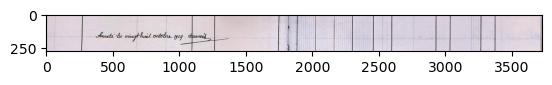

In [148]:
test_image = cv2.imread(test_path)
plt.imshow(test_image)

In [164]:
def easyOCR(image_path):
    reader = easyocr.Reader(['fr'])
    img = cv2.imread(image_path)
    results = reader.readtext(img)
    output = []
    for res in results:
        det, conf = res[1], res[2]
        output.append((det, round(conf, 2))) 
    text = ' '.join([i[0] for i in output])
    return text

In [165]:
test_ocr = easyOCR(test_path)

In [166]:
test_ocr

'~Bcrta` 8 oetolz 1919 d4earuey vicytAul'

### Pytesseract

In [167]:
def pytesseractOCR(image_path):
    try:
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image)
        return text
    except:
        print("[ERROR] pytesseractOCR failed! (should be installed)")
        return ""

In [168]:
test_pytesseract = pytesseractOCR(image_path=test_path)
print(test_pytesseract)

[ERROR] pytesseractOCR failed! (should be installed)



### Keras

Not good for non-english?

In [172]:
def kerasOCR(image_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    image = keras_ocr.tools.read(image_path)
    prediction_groups = pipeline.recognize([image])
    words = []
    for line in prediction_groups[0]:
        for word in line:
            try:
                if isinstance(word[0], str):
                    words.append(word[0])
            except IndexError:
                continue
    text = ' '.join(words)
    return text

In [173]:
test_keras = kerasOCR(image_path=test_path)
print(test_keras)

Looking for /Users/serenekim/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Looking for /Users/serenekim/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 751ms/step
d r p o a g


# Pipeline

In [113]:
gpt4o_texts = []
easyOCR_texts = []
# pytesseract_texts = []
# kerasOCR_texts = []

# for file in images_encoded['file'].unique():
for file in [1]:
    print(f"File: {file}")
    for line in images_encoded[images_encoded['file'] == file]['line']:
        print(f"Line: {line}")
        image_path = image_folder+f'/example{file}_{line}.jpg'
        input_encoded_image = images_encoded[(images_encoded['file'] == file) & (images_encoded['line'] == line) ]['encoded'].values[0]
        
###### GPT-4o
        line_text_gpt4o = callOpenAI(prompt=prompt, max_tokens=800, base64_image = input_encoded_image)
        # print(f"OpenAI: {line_text_gpt4o}")
        postprocessed_gpt40_text = callPostProcessing(max_tokens=800, prompt_parameter = line_text_gpt4o)
        gpt4o_texts.append({'file': file, 'line': line, 'gpt4o_text': postprocessed_gpt40_text})
        line_text_complex = callOpenAI(prompt=prompt_complex, max_tokens=800, base64_image = input_encoded_image)
        print(f"OpenAI Complex: {line_text_complex}")

###### EasyOCR
        line_text_easyOCR = easyOCR(image_path)
    # Question: Will I need to postprocess the EasyOCR text?
        easyOCR_texts.append({'file': file, 'line': line, 'easyOCR_text': line_text_easyOCR})
        # print(f"EasyOCR: {line_text_easyOCR}")

###### Pytesseract
        # line_text_pytesseract = pytesseractOCR(image_path)
        # print(f"Pytesseract: {line_text_pytesseract}")

###### KerasOCR
        # line_text_keras = kerasOCR(image_path)
        # kerasOCR_texts.append({'file': file, 'line': line, 'kerasOCR_text': line_text_keras})
        # print(f"KerasOCR: {line_text_keras}")

gpt4o_texts_df = pd.DataFrame(gpt4o_texts)
easyOCR_texts_df = pd.DataFrame(easyOCR_texts)

File: 1
Line: 00
OpenAI Complex: Here is the transcribed text from the image:

```
N° d'ordre (1) | DATE DU DÉPÔT des DÉCLARATIONS. | DÉSIGNATION DES PERSONNES DÉCÉDÉES, OU ABSENTES. | DATE DU DÉCÈS ou du JUGEMENT D'ENVOI en possession, en cas d'absence. | NOMS, PRÉNOMS ET DEMEURES DES PARTIES DÉCLARANTES. | DROITS DE SUCCESSION EN LIGNE COLLATERALE et de MUTATION EN LIGNE DIRECTE. | DROIT DE MUTATION par décès. | NUMÉROS des DÉCLARATIONS | DATE de l'exigibilité des droits. | NUMÉROS de la consignation des droits au somnier n° 25. | RECETTE des DROITS ET AMENDES. | DATE | N° | CAUTIONNEMENTS. NUMÉROS de la consignation au somnier n° 30. | OBSERVATIONS. (Les déclarations qui figurent à l'état n° 11 doivent être énoncées en exécution, dans la présente colonne.)
```

This transcription captures the headers of the columns in the document.
Line: 01
OpenAI Complex: The text in the image reads:

"Arrêté le vingt huit octobre 1919 servais"
Line: 02
OpenAI Complex: The text in the image reads:


In [114]:
gpt4o_texts_df

,file,line,gpt4o_text
0,1,00,N° d'ordre\nDATE DU DÉPÔT des DÉCLARATIONS\nDÉ...
1,1,01,Societé le vingt huit octobre 1919
2,1,02,Arrêté le vingt neuf octobre 1919 Servais
3,1,03,398 treinte octubre Herrero Alphonse Opheim 29...
4,1,04,398½ d Lefèvre Jules Brulé-L. 8 janvier ...
5,1,05,Avant le trente octobre 1919
6,1,06,Soresti le trent un octob 1929 Servais
7,1,07,Sorreté le premier novembre 1919 Toussaint Ser...
8,1,08,Arresté le deux novembre 1919 Dimanche Servais
9,1,09,```\n399 Crois. 6bre. Desmedt Jeanne Nivelles ...


In [115]:
easyOCR_texts_df

,file,line,easyOCR_text
0,1,00,DÉSIGNATION DES PERSONNES DÉCÉDÉES OU AlSENTES...
1,1,01,~Bcrta` 8 oetolz 1919 d4earuey vicytAul
2,1,02,Jbsucala & veyhmeuf ouoba tg19 [eevœy
3,1,03,891 ta HBevcenk ~Bepkonssjk oj hain Hgoucoal Y...
4,1,04,"TulL Bouuù Q ""Janer ~aobà Bhuile RRXR 26 aplul..."
5,1,05,sueb' Q {cmEE oclb. 1419 dqune
6,1,06,Jsveaki @ bemlL un oelba_-1919 dexl'
7,1,07,kszeté & fummlar nouembas_ 1919 ollsaams Vuser...
8,1,08,Joveal + Jeunx 2ouemba (949 Oùhanebe Fuuunù/
9,1,09,889 644 (esmedk Yenooz Yiveblu 43 m22 euupsek ...
